In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
work_pth = '/content/drive/MyDrive/Lab 2025/Lab7'
os.chdir(work_pth) # customize this line to your working directory


We will use ISLP package to load the IMDB dataset.
The packages will have to be reinstalled each time a new runtime is started. For most labs, inserting pip install ISLP at the top of the notebook will suffice, though Colab will ask you to restart after installation.

In [1]:
import os
!pip install ISLP
import ISLP

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----------------------- ---------------- 6.6/11.1 MB 33.5 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 30.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------- ----------------------- 6.6/15.5 MB 31.0 MB/s eta 0:00:01
   ------------------------------- -------- 12.3/15.5 MB 29.6 MB/s eta 0:00:01
   ---------------------------------------- 15.5/15.5 MB 27.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.8 MB ? eta -:--:--
   ---------------------------------------- 3.8/3.8 MB 22.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ---------------------------- ----------- 4.5/6.2 MB 22.4 MB/s eta 0:00:01
   ---------------------------------------- 6.2/6.2 MB 19.0 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any

In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients
        for data, target in loader:
            # check if cuda is available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = model(data)  # Forward pass
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    model.train()
    return accuracy

# Define a function for training.
def train_model(model, loss_func, num_epochs, optimizer, train_loader, test_loader):

  train_loss_log = []
  train_acc_log = []
  test_acc_log = []

  # Move model to GPU if CUDA is available
  if torch.cuda.is_available():
      model = model.cuda()
  tic = time.time()
  for epoch in range(1,num_epochs+1):
    train_loss = 0
    for i, data in enumerate(train_loader):
      x, y = data
      # check if cuda is available
      if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()
      # get predicted y value from our current model
      pred_y = model(x)
      # calculate the loss
      loss = loss_func(pred_y,y)
      # Zero the gradient of the optimizer
      optimizer.zero_grad()
      # Backward pass: Compute gradient of the loss with respect to model parameters
      loss.backward()
      # update weights ar
      optimizer.step()
      train_loss += loss.item() * len(x)
    # change the model to evaluation mode to calculate the test loss; We will come back to this later after learning Dropout and Batch Normalization
    train_loss/=len(train_loader)
    train_loss_log.append(train_loss)
    train_acc = calculate_accuracy(train_loader, model)
    test_acc = calculate_accuracy(test_loader, model)
    train_acc_log.append(train_acc)
    test_acc_log.append(test_acc)
    print("Epoch {:2},  Training Loss: {:9.4f}, Training Accuracy: {:9.2f},  Test Accuracy: {:7.2f}".format(epoch, train_loss, train_acc, test_acc))
  toc = time.time()
  print("Elapsed Time : {:7.2f}".format(toc-tic))
  return train_loss_log, train_acc_log, test_acc_log

In [3]:
import ISLP
import numpy as np

We will be using build-in functions in ISLP to preprocess the IMDB dataset.

- load_tensor(), a sparse tensor version usable by torch;
- load_sparse(), a sparse matrix version usable by sklearn, since we
will compare with a lasso fit;
- load_sequential(), a padded version of the original sequence representation,
limited to the last 500 words of each review. In the preprocessing used to form these data, sequences
were padded with 0s in the beginning if they were not long enough.

In [4]:
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)

(imdb_seq_train,
 imdb_seq_test) = load_sequential(root='data/imdb')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0]
sample_review[:12]

Retrieving "IMDB_S_train.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


C:\Users\ATHARV\AppData\Roaming\Python\Python312\site-packages\ISLP\torch\imdb.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  S_test) = [torch.load(_get_imdb(f'IMDB_{

Retrieving "IMDB_S_test.tensor.gz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_test.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_Y_train.npy" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468])

In the IMDB dataset, the `<UNK>` and `<UNUSED>` tokens serve distinct purposes in handling vocabulary and reserved words:

1. `<UNK> `(Unknown Token)

Represents out-of-vocabulary (OOV) words.
If a word is not in the predefined vocabulary (e.g., because of truncation or unseen words in the test set), it is replaced with `<UNK>`.
Ensures that the model can still process the text, even if some words are missing.

2. `<UNUSED>` Tokens

These are reserved tokens that are not actively used in training but can be repurposed.
In the IMDB dataset, token indices 3 and above are assigned to words in the dataset's vocabulary, while indices below 3 are often reserved (e.g., `<PAD>`, `<START>`, `<UNK>`).
Some `<UNUSED>` tokens exist as placeholders for potential extensions or modifications.

Why Are `<UNUSED>` Tokens There?

In TensorFlow's IMDB dataset (tf.keras.datasets.imdb.load_data()), word indices are assigned dynamically based on frequency. Some indices in the vocabulary may not be assigned to any word and are marked as `<UNUSED>`.
Developers can manually assign new meanings to these tokens if they wish to expand the vocabulary.

In [5]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's really suited <UNUSED> part they played and you could just imagine being there robert <UNK> is an amazing actor and now <UNUSED> same being director <UNK> father came from <UNUSED> same scottish island as myself so i loved <UNUSED> fact there was a real connection with this film <UNUSED> witty remarks throughout <UNUSED> film were great it was just brilliant so much that i bought <UNUSED> film as soon as it was released for <UNK> and would recommend it to everyone to watch and <UNUSED> fly fishing was amazing really cried at <UNUSED> end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to <UNUSED> two little boy's that played <UNUSED> <UNK> of norman and paul they were just brilliant children are often left out of <UNUSED> <UNK> list i think because <UNUSED> stars that play them all grown up are such a big profile for <UNUSED> 

### Text Data

Each text sample should be length 500. We can interpret each text as a sequential input with 500 length.

In [6]:
imdb_seq_train[1][0].shape

torch.Size([500])

In [7]:
imdb_seq_train[1][0]

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [8]:
imdb_seq_train[1][1]

tensor(0.)

In [9]:
# Convert the label dtype to torch.long

from torch.utils.data import TensorDataset

# Step 1: Extract tensors from the existing TensorDataset
train_texts, train_labels = imdb_seq_train.tensors
test_texts, test_labels = imdb_seq_test.tensors

# Step 2: Convert the labels tensor to torch.long
train_labels_long = train_labels.long()
test_labels_long = test_labels.long()

# Step 3: Create new TensorDataset instances with the updated labels tensor
imdb_seq_train = TensorDataset(train_texts, train_labels_long)
imdb_seq_test = TensorDataset(test_texts, test_labels_long)


In [10]:
from torch.utils.data import DataLoader

trainloader = DataLoader(imdb_seq_train,batch_size=64,shuffle=True)
testloader = DataLoader(imdb_seq_test, batch_size=64,shuffle=False)

### Simple RNN Structure



$$ h_t = \sigma\left( W_{hx} x_t + b_{xh} + W_{hh} h_{t-1} + b_{hh} \right) $$

where $x$ is the dimension of each word $x_t$, $h$ being the hidden dimension, $\sigma$ being activation function such as ReLU or tanh


In [1]:
#from IPython.display import Image
#Image('SimpleRNN.PNG')

### Word Embedding

Word embedding is a term used in natural language processing (NLP) to describe a set of language modeling and feature learning techniques where words or phrases from the vocabulary are mapped to vectors of real numbers in a low-dimensional space, relative to the vocabulary size. This process involves representing words in a dense vector form that captures semantic relationships and meanings.

Before word embedding, the dimension of each word $x_t$ is equal to the size of the vocabulary dictionary which is 10003 in IMDB dataset. That is, we need to use one-hot encoded vector with length 10003 to represent each word. This will make our input data size to be 500 x 10003 which is quite huge. Therefore, we would like to use word embedding to reduce the dimension of each word vector. Followings are the two important things about word embedding:

- Semantic Representation: Word embeddings aim to capture the semantic meaning of words, such that words with similar meanings are located close to each other in the embedding space.
- Dimensionality Reduction: They reduce the dimensionality of the word representation compared to one-hot encoding, where the vector size equals the vocabulary size, with a single high (1) value for the word and 0s for all other words. This not only saves space but also improves computational efficiency.

There are two ways to implement word embedding in our model. One is to train model by ourselves and the other is to use pre-trained embeddings such as Word2Vec or GloVe.
In this lab, we will train the word embedding by ourselves.

#### Note: Document Embedding vs Word Embedding

Document embedding is to capture the overall semantic meaning of the text at a higher level than individual words or phrases. An example of a document embedding technique is the bag-of-words model, which, despite its simplicity, serves as a foundational approach by treating texts as collections of their constituent words, disregarding syntax and word order. Furthermore, document embedding can be achieved through the aggregation of word embeddings, wherein each document is perceived as a sequence of vectors in the embedded space of words.

In [12]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, nonlinearity='relu', output_dim=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # Instead of using the pre-trained embeddings, such as Word2Vec, GloVe, let us train the embedding  by ourselves.
        self.rnn = nn.RNN(embedding_dim, hidden_dim,num_layers=1, nonlinearity=nonlinearity, batch_first=True) # We can also add dropout layers on the outputs of the RNN layers, by passing dropout argument to the RNN class
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]
        all_h, last_h = self.rnn(embedded)
        # all_h = [batch size, sent len, hid dim]
        # last_h = [1, batch size, hid dim]
        last_h = last_h.squeeze(0)
        # last_h = [batch size, hid dim]
        out = self.fc(last_h)
        return out


In [13]:
# Hyperparameters
VOCAB_SIZE = 10003  # 10000 words in the dictionary + <START>, <UNK>, <UNUNSED>
EMBEDDING_DIM = 128 #32
HIDDEN_DIM = 64 #32
nonlinearity = 'relu'
learning_rate = 4e-4
epoch = 20
# Instantiate the model
simple_rnn_relu = SimpleRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, nonlinearity=nonlinearity)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_rnn_relu.parameters(), lr=learning_rate)

# test accuracy will be around 85 for smaller embedding and hidden dimensions
train_loss_simple_rnn, train_acc_log_simple_rnn, test_acc_log_simple_rnn = train_model(simple_rnn_relu, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   43.4862, Training Accuracy:     62.80,  Test Accuracy:   59.91
Epoch  2,  Training Loss:   43.4892, Training Accuracy:     66.62,  Test Accuracy:   62.46
Epoch  3,  Training Loss:   37.7732, Training Accuracy:     70.28,  Test Accuracy:   65.62
Epoch  4,  Training Loss:   34.1485, Training Accuracy:     77.40,  Test Accuracy:   73.67
Epoch  5,  Training Loss:   28.8257, Training Accuracy:     80.26,  Test Accuracy:   75.79
Epoch  6,  Training Loss:   24.7275, Training Accuracy:     86.18,  Test Accuracy:   80.93
Epoch  7,  Training Loss:   21.5849, Training Accuracy:     88.37,  Test Accuracy:   82.66
Epoch  8,  Training Loss:   20.4089, Training Accuracy:     89.92,  Test Accuracy:   83.37
Epoch  9,  Training Loss:   17.5995, Training Accuracy:     86.67,  Test Accuracy:   81.14
Epoch 10,  Training Loss:   17.4847, Training Accuracy:     90.65,  Test Accuracy:   84.13
Epoch 11,  Training Loss:   15.3454, Training Accuracy:     92.56,  Test Accuracy:   85.18

#### Logistic Regression with Lasso and Bag of Words Technique


This achieves higher test accuracy than simple RNN, indicating that simple RNN is not efficient enough on processing the test data.

One possible reason is the small embbeding/hidden dimensions due to computation time limit.

Another is that we are not using any pretrained word embedding models, but instead training by ourselves. To obtain a good word embedding model, usually one needs a large training set. However, we are only using 25000 training samples.

In [14]:
((X_train, Y_train),
 (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation=2000,
                                 random_state=0,
                                 root='data/IMDB')
print(X_train.shape, X_valid.shape, X_test.shape)

Retrieving "IMDB_X_test.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
Retrieving "IMDB_X_train.npz" from "http://imdb.jtaylor.su.domains/jtaylor/data/".
(23000, 10003) (2000, 10003) (25000, 10003)


In [15]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
# Try 50 different Lambda values
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))


In [16]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1',
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)

In [17]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [18]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

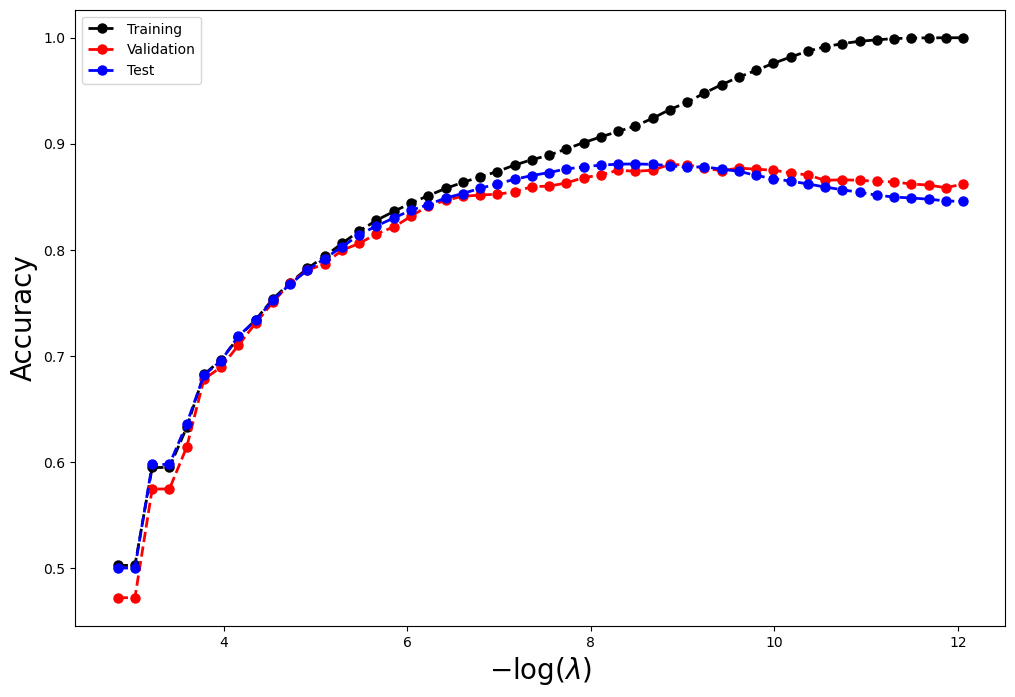

In [19]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                   ['Training', 'Validation', 'Test'],
                   ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    ax.plot(-np.log(lam_val / X_train.shape[0]),
            accuracy_,
            '.--',
            color=color,
            markersize=13,
            linewidth=2,
            label=data_)
    if data_ == 'Validation':
      val_acc = accuracy_
    elif data_ == 'Test':
      test_acc = accuracy_

ax.legend()
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
plt.show()

In [20]:
# Find the index of the maximum value in val_acc
index_of_max_val_acc = np.argmax(val_acc)
# Use this index to retrieve the corresponding value from test_acc
log_reg_test_acc = test_acc[index_of_max_val_acc]
log_reg_test_acc

0.87936

### Multi-layer RNN

We can also stack the RNN layers on top of other RNN layers.

In [ ]:
from IPython.display import Image
Image('DeepRNN.PNG')


In [21]:
class TwoLayerRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, nonlinearity='relu', output_dim=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # Instead of using the pre-trained embeddings, such as Word2Vec, GloVe, let us train the embedding  by ourselves.
        self.rnn1 = nn.RNN(embedding_dim, hidden_dim1, num_layers=1, nonlinearity=nonlinearity,batch_first=True) # We can also add dropout layers on the outputs of the RNN layers, by passing dropout argument to the RNN class
        self.rnn2 = nn.RNN(hidden_dim1, hidden_dim2, num_layers=1, nonlinearity=nonlinearity,batch_first=True)
        self.fc = nn.Linear(hidden_dim2, output_dim)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]
        all_h, last_h = self.rnn1(embedded)
        # all_h = [batch size, sent len, hid dim1]
        # last_h = [1, batch size, hid dim1]
        # Mini Exercise: What would be the input for self.rnn2?
        all_h, last_h = self.rnn2(all_h)
        # all_h = [batch size, sent len, hid dim2]
        # last_h = [1, batch size, hid dim2]
        last_h = last_h.squeeze(0)
        # hidden = [batch size, hid dim]
        out = self.fc(last_h)
        return out


In [22]:
# Hyperparameters
VOCAB_SIZE = 10003  # 10000 words in the dictionary + <START>, <UNK>, <UNUNSED>
EMBEDDING_DIM = 128
HIDDEN_DIM1 = 128
HIDDEN_DIM2 = 64
nonlinearity = 'relu'
learning_rate = 4e-4
epoch = 20
# Instantiate the model
two_layer_rnn_relu = TwoLayerRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2,nonlinearity=nonlinearity)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(two_layer_rnn_relu.parameters(), lr=learning_rate)

train_loss_two_rnn, train_acc_log_two_rnn, test_acc_log_two_rnn = train_model(two_layer_rnn_relu, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   41.7287, Training Accuracy:     68.66,  Test Accuracy:   65.79
Epoch  2,  Training Loss:   35.9504, Training Accuracy:     76.33,  Test Accuracy:   72.32
Epoch  3,  Training Loss:   30.3810, Training Accuracy:     79.70,  Test Accuracy:   74.79
Epoch  4,  Training Loss:   47.0821, Training Accuracy:     70.55,  Test Accuracy:   66.61
Epoch  5,  Training Loss:   32.8917, Training Accuracy:     80.02,  Test Accuracy:   76.02
Epoch  6,  Training Loss:   28.7052, Training Accuracy:     79.52,  Test Accuracy:   75.08
Epoch  7,  Training Loss:   28.8984, Training Accuracy:     81.17,  Test Accuracy:   75.15
Epoch  8,  Training Loss:   29.1883, Training Accuracy:     83.51,  Test Accuracy:   78.96
Epoch  9,  Training Loss:   26.2306, Training Accuracy:     85.48,  Test Accuracy:   79.60
Epoch 10,  Training Loss:   25.3176, Training Accuracy:     81.74,  Test Accuracy:   75.23
Epoch 11,  Training Loss:   29.3557, Training Accuracy:     66.06,  Test Accuracy:   60.30

In [23]:
class DeepRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, nonlinearity='relu', output_dim=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # Instead of using the pre-trained embeddings, such as Word2Vec, GloVe, let us train the embedding  by ourselves.
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, nonlinearity=nonlinearity, batch_first=True) # We can also add dropout layers on the outputs of the RNN layers, by passing dropout argument to the RNN class
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]
        all_h, last_h = self.rnn(embedded)
        # all_h = [batch size, sent len, last hid dim]
        # last_h = [num_layers, batch size, last hid dim]
        last_layer_h = last_h[-1,:,:]  # Get the last layer's hidden states for all batches, [batch size, hid dim]
        # last_h = [batch size, hid dim]
        out = self.fc(last_layer_h)
        return out


In [24]:
# Hyperparameters
VOCAB_SIZE = 10003  # 10000 words in the dictionary + <START>, <UNK>, <UNUNSED>
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
num_layers = 3
nonlinearity = 'tanh'
learning_rate = 1e-4
epoch = 40
# Instantiate the model
deep_rnn_relu = DeepRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, num_layers=num_layers, nonlinearity=nonlinearity)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_rnn_relu.parameters(), lr=learning_rate)

train_loss_deep_rnn, train_acc_log_deep_rnn, test_acc_log_deep_rnn = train_model(deep_rnn_relu, loss_func, epoch, optimizer, trainloader, testloader)

Epoch  1,  Training Loss:   43.7239, Training Accuracy:     58.90,  Test Accuracy:   57.67
Epoch  2,  Training Loss:   40.4905, Training Accuracy:     69.62,  Test Accuracy:   68.32
Epoch  3,  Training Loss:   37.3096, Training Accuracy:     72.10,  Test Accuracy:   70.62
Epoch  4,  Training Loss:   37.4584, Training Accuracy:     64.47,  Test Accuracy:   62.14
Epoch  5,  Training Loss:   38.2913, Training Accuracy:     62.66,  Test Accuracy:   62.32
Epoch  6,  Training Loss:   38.8433, Training Accuracy:     69.12,  Test Accuracy:   66.23
Epoch  7,  Training Loss:   36.7984, Training Accuracy:     73.13,  Test Accuracy:   71.07
Epoch  8,  Training Loss:   36.4134, Training Accuracy:     71.27,  Test Accuracy:   68.10
Epoch  9,  Training Loss:   34.4103, Training Accuracy:     75.30,  Test Accuracy:   72.68
Epoch 10,  Training Loss:   30.9758, Training Accuracy:     78.04,  Test Accuracy:   75.13
Epoch 11,  Training Loss:   29.4091, Training Accuracy:     79.24,  Test Accuracy:   76.13

In [25]:
# Compare the test accuracy of the three models as pandas dataframe

import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame({'Logistic Regression':[round(log_reg_test_acc*100,3)],'Simple RNN': [max(test_acc_log_simple_rnn)], 'Two Layer RNN': [max(test_acc_log_two_rnn)], 'Deep RNN': [max(test_acc_log_deep_rnn)]})
df

,Logistic Regression,Simple RNN,Two Layer RNN,Deep RNN
0,87.936,85.412,85.116,85.232
